In [72]:
using Flux
using IterTools: ncycle
using Plots

# Note
We will heavily "overfit" this data as a demonstration of the functions, in practice this may not be ideal.

# Establish "target" data

As a simple example we will just try to fit the function y = x^2

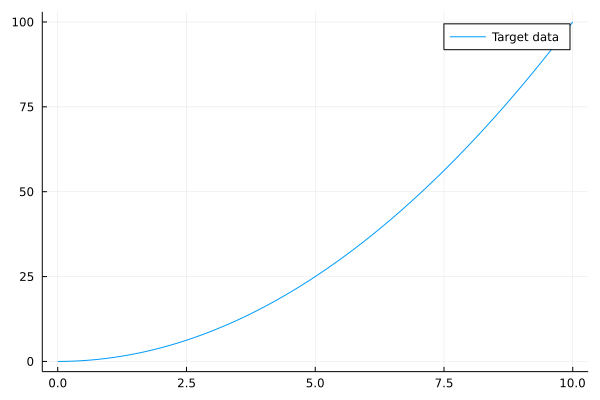

In [73]:
test_func(x) = x^2

x_start = 0.0
x_step = 0.1
x_end = 10.0
x_target = collect(x_start:x_step:x_end)

y_target = test_func.(x_target)

plot(x_target,y_target,label="Target data")

# Define model to fit target data

We use a neural network with 1 input layer, 2 hidden layers with 4096 weight parameters and 64 bias parameters each, and the "relu" activation function between the layers

In [74]:
model =  Chain(
  Dense(1, 64),
  Dense(64, 64, relu),
  Dense(64, 64, relu),
  Dense(64, 1)
)

Chain(
  Dense(1 => 64),                       # 128 parameters
  Dense(64 => 64, relu),                # 4_160 parameters
  Dense(64 => 64, relu),                # 4_160 parameters
  Dense(64 => 1),                       # 65 parameters
)                   # Total: 8 arrays, 8_513 parameters, 33.754 KiB.

Examine how the parameters are initialized

In [75]:
model[2].bias'      # ' used to transpose output for space efficiency. We are examining the bias vector of the first hidden layer, and we note it is initialized to 0 by default

1×64 adjoint(::Vector{Float32}) with eltype Float32:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0

In [76]:
model[3].weight     # Weights are initialized randomly according to "glorot_uniform" distribution by default (see source code for "Dense" in Flux)

64×64 Matrix{Float32}:
 -0.185976    -0.103006    -0.0568205   …   0.118822    -0.211537
 -0.141076    -0.0624069   -0.184424       -0.0420671   -0.0771946
  0.00620457  -0.00394654   0.0959885      -0.126091     0.135211
  0.0442012   -0.162001     0.172388        0.0102828   -0.013654
 -0.0728863    0.0992874   -0.149698        0.0919202   -0.179818
 -0.174696    -0.0462965    0.160321    …  -0.215279    -0.101285
  0.0233884   -0.0820745   -0.196701        0.152995    -0.171624
 -0.190016    -0.180562     0.0622964      -0.143289    -0.210439
  0.104146    -0.070255    -0.0865493       0.106959     0.167517
 -0.0580538    0.21285     -0.157791       -0.00172847   0.0285433
  ⋮                                     ⋱               
  0.0637336   -0.195012    -0.0977686   …   0.116304    -0.138404
 -0.0615743    0.0784403    0.118419       -0.103282    -0.078477
 -0.20211     -0.140806    -0.214063        0.070126    -0.110534
 -0.0625539    0.0439876   -0.128528       -0.0613433   -0.0

Lets look at the initial comparison of model to target data

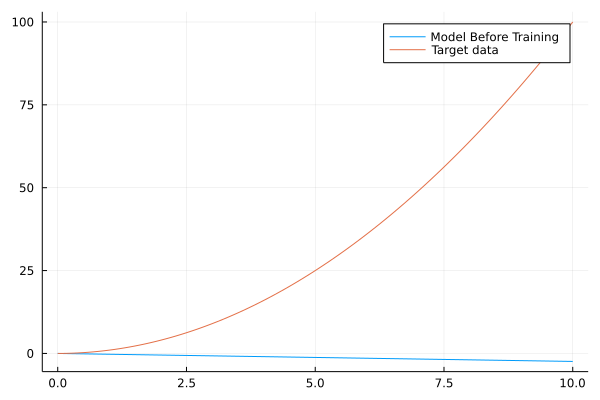

In [77]:
plot(x_target,model(x_target')', label="Model Before Training")
plot!(x_target,y_target,label="Target data")

# Define training regime for model parameters

In [78]:
# Define loss function as "mean square error": sum over each target data point (x,y) the quantity (model(x) - y)^2
loss(x, y) = Flux.Losses.mse(model(x), y)

# Extract all parameters of the model, of which there are 8,513 (see output of "model" definition cell)
params = Flux.params(model)

# most convenient way to put target data in the format that the model training function expects
training_data = Flux.Data.DataLoader((x_target, y_target),shuffle=true)     # Shuffling the data on each training iteration improves the fit greatly

# Choose an optimizer (how parameters are adjusted based on a training step)
opt = ADAM()    # A common stochastic gradent descent optimizer

ADAM(0.001, (0.9, 0.999), 1.0e-8, IdDict{Any, Any}())

# Train model according to chosen loss function

In [79]:
Flux.train!(loss, params, ncycle(training_data, 300), opt) # ncycle repeats the training step 300 times here, as by default train! only does one step. 

We could also have done 

In [80]:
# using Flux: @epochs
#
# @epochs 100 Flux.train!(loss, params, training_data, opt)

# Display results of model optimization

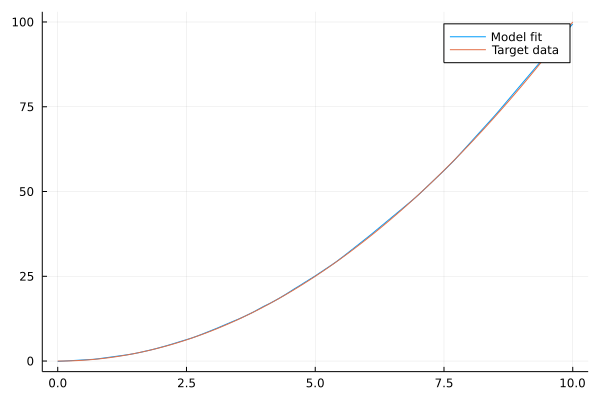

In [81]:
plot(x_target,model(x_target')', label="Model fit")
plot!(x_target,y_target,label="Target data")

In [82]:
model[2].bias' # Some parameters which have been adjusted (were previously all 0)

1×64 adjoint(::Vector{Float32}) with eltype Float32:
 -0.29489  0.0  -0.157418  -0.0777873  …  -0.019417  -0.0464712  0.204325